In [1]:
from Bayesian_Neural_Network import bayesian_neural_network
from BNN_Learning_Rate_Tuning import bnn_learning_rate_tuning

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

np.random.seed(10120024)

# Data Preparation

In [2]:
# load the dataset
df = pd.read_csv('fraud.csv', 
                    usecols=['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud'], 
                    nrows=2500)

# perform one-hot-eencoding on the column 'type'
dummies_df = pd.get_dummies(df['type'], dtype=int)

# concat the original data with the one-hot-encoded data
data = pd.concat((df, dummies_df), axis=1) \
            .drop(columns=['type'])

In [3]:
# percentage of fraud and non-fraud label in the data
data['isFraud'].value_counts().to_frame('percentage') / np.sum(data['isFraud'].value_counts()) * 100

,percentage
isFraud,
0,99.36
1,0.64


In [4]:
# specify the feature and target data
feature_columns = data.columns[data.columns != 'isFraud']
target_columns = ['isFraud']

feature_data = data.loc[:, feature_columns]
target_data = data.loc[:, target_columns]

# standardize the dataset
for col in feature_columns:
    scaler = StandardScaler()
    feature_data[col] = scaler.fit_transform(feature_data[col].values.reshape(-1, 1))

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5)

feature_data_values = pca.fit_transform(feature_data.values)
feature_data = pd.DataFrame({f'PCA {i+1}':val for i, val in enumerate(feature_data_values.T)})
feature_columns = feature_data.columns

explained_variance = pca.explained_variance_ratio_

In [6]:
fraud_feature_data = feature_data.loc[target_data['isFraud'] == 1, :].values
fraud_target_data = target_data.loc[target_data['isFraud'] == 1, :].values 

non_fraud_feature_data = feature_data.head(25).loc[target_data['isFraud'] == 0, :].values
non_fraud_target_data = target_data.head(25).loc[target_data['isFraud'] == 0, :].values

fraud_non_fraud_feature_data = np.concatenate((fraud_feature_data, non_fraud_feature_data), axis=0)
fraud_non_fraud_target_data = np.concatenate((fraud_target_data, non_fraud_target_data), axis=0)

# Model Performance on Predicting Fraud Data (Labeled as 1)

In [7]:
input_layer = [len(feature_columns)]
hidden_layers = [32, 16, 8, 4, 2]
output_layer = [1]

total_epochs = 150
initial_lr = 1e-5
end_lr = 1
validation_percentage = 0.1
batch_size = 4

model_purpose = 'binary'
learning_rate_decay_type = 'exponential'

In [10]:
bnn = bayesian_neural_network(input_layer, 
                                hidden_layers, 
                                output_layer, 
                                fraud_feature_data, 
                                fraud_target_data, 
                                validation_percentage=validation_percentage, 
                                model_purpose='binary', 
                                batch_size=batch_size,
                                initial_lr=initial_lr, 
                                end_lr=end_lr,
                                learning_rate_decay_type=learning_rate_decay_type,
                                total_epochs=total_epochs)

# model performance after training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data, bnn.model_structure, model_purpose=bnn.model_purpose)[0]

array([0.272, 0.292, 0.272, 0.292, 0.276, 0.284, 0.292, 0.276, 0.288,
       0.276, 0.284, 0.276, 0.288, 0.288])

In [11]:
bnn.train_model()

------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 1 / 150 - Learning Rate : 0.006666666666666665 - Succesfull Train Percentage : 100.0% - Time Passed : 0.09 Second
Accuracy : 0.0% - Standard Deviation : 0.436991612687604
Validation Accuracy : 0.0% - Validation Standard Deviation : 0.46188104358019144
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 2 / 150 - Learning Rate : 0.01333333333333333 - Succesfull Train Percentage : 100.0% - Time Passed : 0.08 Second
Accuracy : 0.0% - Standard Deviation : 0.45976500671862613
Validation Accuracy : 0.0% - Validation Standard Deviation : 0.44178704692361953
--------------------------

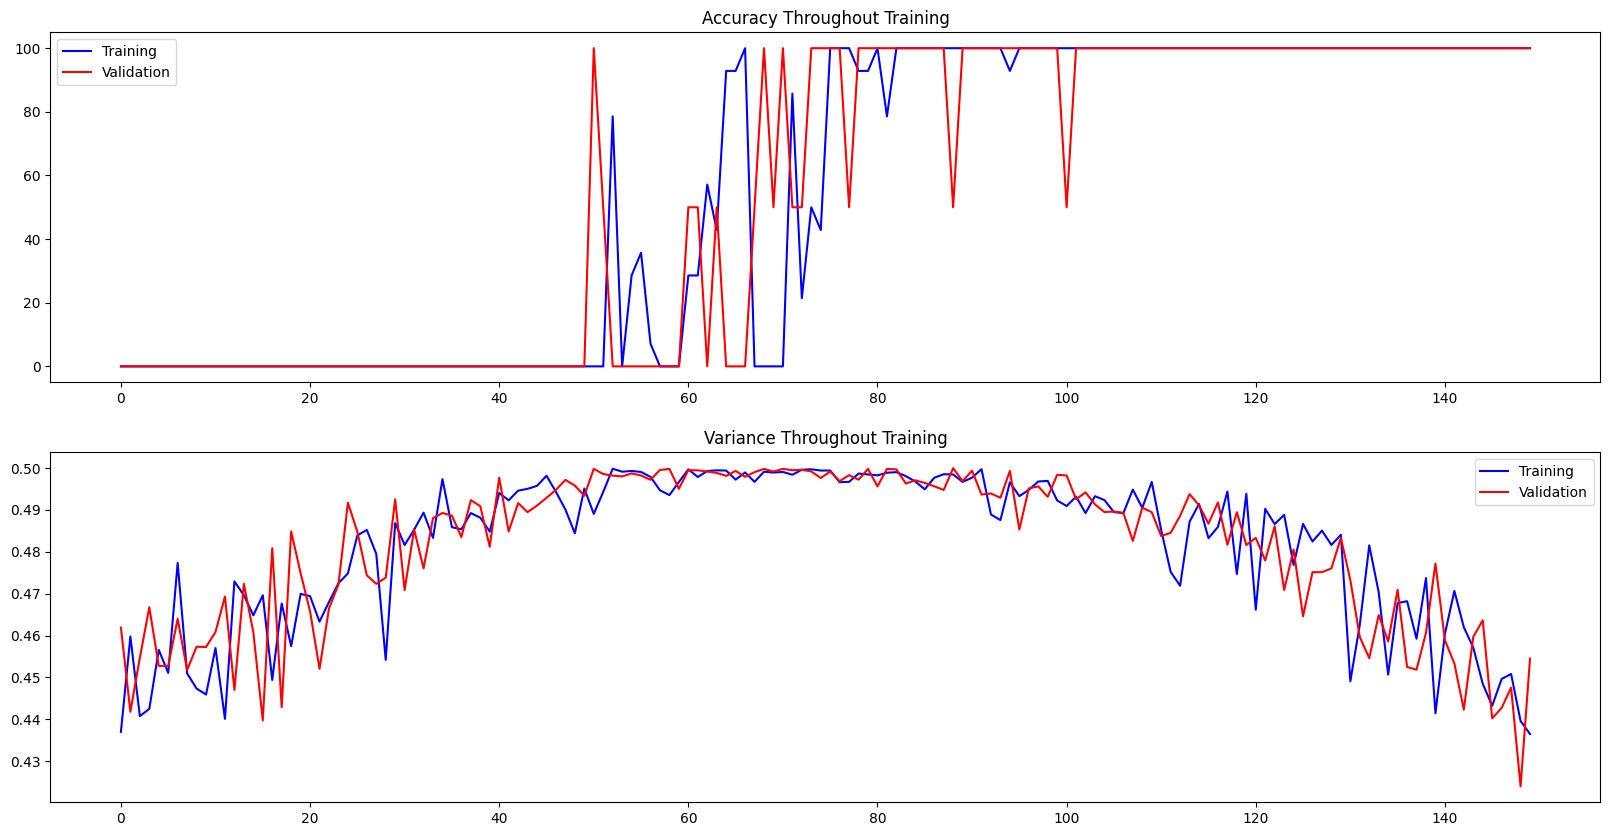

In [12]:
bnn.visualize_model_performance()

In [13]:
# model performance after training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data, bnn.model_structure, model_purpose=bnn.model_purpose)[0]

array([0.696, 0.72 , 0.696, 0.72 , 0.696, 0.72 , 0.704, 0.704, 0.756,
       0.712, 0.72 , 0.7  , 0.72 , 0.724])

# Model Performance on Predicting Non-Fraud Data (Labeled With -1)

In [14]:
input_layer = [len(feature_columns)]
hidden_layers = [32, 16, 8, 4, 2]
output_layer = [1]

total_epochs = 100
initial_lr = 1e-6
end_lr = 1e-3
validation_percentage = 0.1
batch_size = 4

model_purpose = 'binary'
learning_rate_decay_type = 'exponential'

In [21]:
bnn = bayesian_neural_network(input_layer, 
                                hidden_layers, 
                                output_layer, 
                                non_fraud_feature_data, 
                                non_fraud_target_data, 
                                validation_percentage=validation_percentage, 
                                model_purpose='binary', 
                                batch_size=batch_size,
                                initial_lr=initial_lr, 
                                end_lr=end_lr,
                                learning_rate_decay_type=learning_rate_decay_type,
                                total_epochs=total_epochs)

# model performance after training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data, bnn.model_structure, model_purpose=bnn.model_purpose)[0]

array([0.568, 0.552, 0.552, 0.552, 0.568, 0.568, 0.552, 0.524, 0.524,
       0.552, 0.552, 0.552, 0.556, 0.508, 0.552, 0.552, 0.552, 0.536,
       0.552, 0.524])

In [22]:
bnn.train_model()

------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 1 / 100 - Learning Rate : 1e-05 - Succesfull Train Percentage : 100.0% - Time Passed : 0.11 Second
Accuracy : 95.0% - Standard Deviation : 0.4998150941320182
Validation Accuracy : 100.0% - Validation Standard Deviation : 0.4972694539264162
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 2 / 100 - Learning Rate : 2e-05 - Succesfull Train Percentage : 100.0% - Time Passed : 0.09 Second
Accuracy : 75.0% - Standard Deviation : 0.4999327946229813
Validation Accuracy : 100.0% - Validation Standard Deviation : 0.4972100490335607
---------------------------------------------------

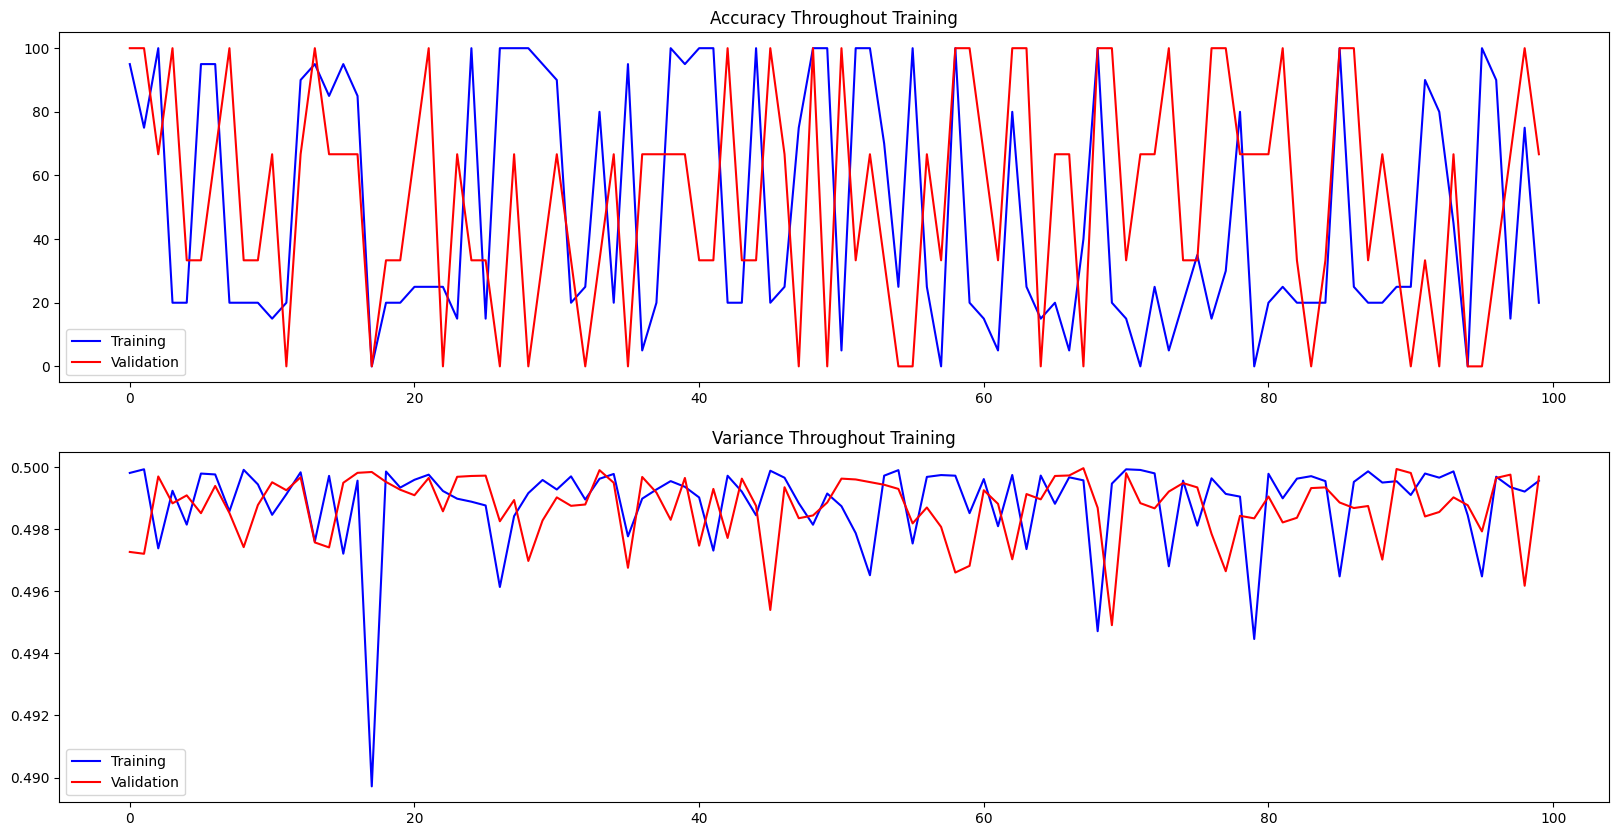

In [23]:
bnn.visualize_model_performance()

In [24]:
# model performance after training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data, bnn.model_structure, model_purpose=bnn.model_purpose)[0]

array([0.516, 0.512, 0.516, 0.512, 0.516, 0.516, 0.512, 0.452, 0.456,
       0.512, 0.512, 0.512, 0.552, 0.464, 0.512, 0.512, 0.512, 0.484,
       0.512, 0.452])

# Model Performance on Fraud and Non-Fraud Data

In [ ]:
input_layer = [len(feature_columns)]
hidden_layers = [32, 16, 8, 4, 2]
output_layer = [1]

total_epochs = 100
initial_lr = 1e-6
end_lr = 1e-3
validation_percentage = 0.1
batch_size = 4

model_purpose = 'binary'
learning_rate_decay_type = 'exponential'

In [ ]:
bnn = bayesian_neural_network(input_layer, 
                                hidden_layers, 
                                output_layer, 
                                non_fraud_feature_data, 
                                non_fraud_target_data, 
                                validation_percentage=validation_percentage, 
                                model_purpose='binary', 
                                batch_size=batch_size,
                                initial_lr=initial_lr, 
                                end_lr=end_lr,
                                learning_rate_decay_type=learning_rate_decay_type,
                                total_epochs=total_epochs)


In [ ]:
# model performance on predicting fraudulent data before training
fraud_before = bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data[bnn.target_data == 1], bnn.model_structure, model_purpose=bnn.model_purpose)[0]
fraud_before

In [ ]:
# model performance on predicting non-fraudulent data before training
non_fraud_before = bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data[bnn.target_data == 0], bnn.model_structure, model_purpose=bnn.model_purpose)[0]
non_fraud_before

In [ ]:
bnn.train_model()

In [ ]:
bnn.visualize_model_performance()

In [ ]:
# model performance on predicting fraudulent data before training
fraud_after = bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data[bnn.target_data == 1], bnn.model_structure, model_purpose=bnn.model_purpose)[0]
fraud_after

In [ ]:
# model performance on predicting non-fraudulent data before training
non_fraud_after = bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data[bnn.target_data == 0], bnn.model_structure, model_purpose=bnn.model_purpose)[0]
non_fraud_after

# Model Learning Rate Tuning

In [ ]:
input_layer = [len(feature_columns)]
hidden_layers = [32, 16, 8, 4, 2]
output_layer = [1]

initial_lr_power = 20
end_lr_power = 24
total_iters = 4
tuning_epochs = 10

model_purpose = 'binary'

In [ ]:
bnn_lr_tuning = bnn_learning_rate_tuning(input_layer, 
                                         hidden_layers, 
                                         output_layer, 
                                         feature_data, 
                                         target_data,
                                         model_purpose=model_purpose, 
                                         initial_lr_power=initial_lr_power, 
                                         end_lr_power=end_lr_power, 
                                         total_iters=total_iters, 
                                         tuning_epochs=tuning_epochs)

In [ ]:
bnn_lr_tuning.perform_learning_rate_tuning()

In [ ]:
bnn_lr_tuning.visualize_learning_rate_tuning()